# Climate Analysis and Exploration

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime 

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Columns of the table Measurement

measurement_cols = inspector.get_columns('measurement')

for c in measurement_cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Columns of the table Station

station_cols = inspector.get_columns('station')

for c in station_cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Calculate the date 1 year ago from the last data point in the database

from dateutil.relativedelta import relativedelta

DATE_FORMAT = '%Y-%m-%d'
recent_measurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = datetime.datetime.strptime(recent_measurement.date, DATE_FORMAT).date()
date_one_year_ago =  recent_date - relativedelta(years=1)
print("Date from a year ago", date_one_year_ago)


Date from a year ago 2016-08-23


In [14]:
# Perform a query to retrieve the date and precipitation scores

query = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= date_one_year_ago)\
    .order_by(Measurement.date)



In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

pd_frame = pd.read_sql(query.statement, query.session.bind)
pd_frame.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [16]:
pd_frame = pd_frame.set_index('date')
pd_frame.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [17]:
import os
os.getcwd()

'/Users/sruthi/data-science-bootcamp/assignment-repos/Assignment-8-SQLAlchemy/Homework'

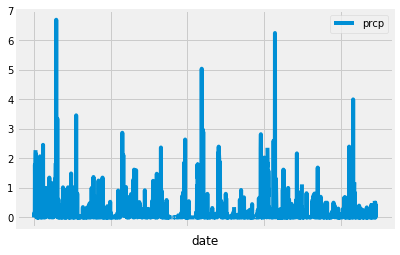

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data

pd_frame.plot()

plt.savefig("Images/precipitation.png")

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

pd_frame.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(func.count(Station.station)).all()

number_of_stations

[(9)]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_recorded = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter_by(station = 'USC00519281').all()
lowest_temp = temp_recorded[0][0]
highest_temp = temp_recorded[0][1]
average_temp = temp_recorded[0][2]

print(temp_recorded)
print()
print('Lowest Temperature Recorded:'+ str(lowest_temp))
print('Highest Temperature Recorded:'+ str(highest_temp))
print('Average Temperature Recorded:'+ str(average_temp))




[(54.0, 85.0, 71.66378066378067)]

Lowest Temperature Recorded:54.0
Highest Temperature Recorded:85.0
Average Temperature Recorded:71.66378066378067


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [24]:
highest_tobs_station = session.query(Measurement.station, func.count(Measurement.station), Measurement.tobs).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

print("Station with highest number of temperature observations = " + str(highest_tobs_station[0]))

Station with highest number of temperature observations = USC00519281


In [25]:
query_temp = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date >= date_one_year_ago)\
    .filter_by(station = 'USC00519281')\
    .order_by(Measurement.date)
    


In [26]:
# Save the query results as a Pandas DataFrame and set the index to the date column

pd_frame_temp = pd.read_sql(query_temp.statement, query_temp.session.bind)
pd_frame_temp = pd_frame_temp.set_index('date')

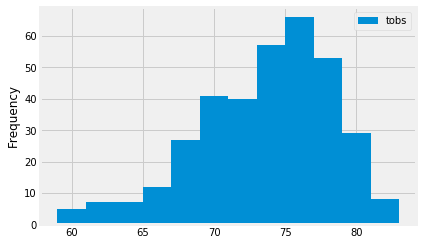

In [27]:
# Plot the results as a histogram

pd_frame_temp.plot(kind='hist', bins=12)

plt.savefig("Images/Temperature.png")

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()



In [29]:
# Calculate minimum, average, and maximum temperatures for that range of dates

print(calc_temps('2016-01-26', '2016-02-08'))

[(56.0, 69.36363636363636, 78.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = datetime.datetime.strptime('2016-01-26', DATE_FORMAT).date()
end_date = datetime.datetime.strptime('2016-02-08', DATE_FORMAT).date()
previous_yr_start_date = start_date - relativedelta(years=1)
previous_yr_end_date = end_date - relativedelta(years=1)

In [31]:
previous_yr_start_date 

datetime.date(2015, 1, 26)

In [32]:
previous_yr_end_date

datetime.date(2015, 2, 8)

In [33]:
[(tmin, tavg, tmax)] = calc_temps(previous_yr_start_date ,previous_yr_end_date)
print('Minimum Temperature for the year 2015 = ' + str(tmin))
print('Maximum Temperature for the year 2015 = ' + str(tmax))
print('Average Temperature for the year 2015 = ' + str(tavg))

Minimum Temperature for the year 2015 = 58.0
Maximum Temperature for the year 2015 = 77.0
Average Temperature for the year 2015 = 69.03191489361703


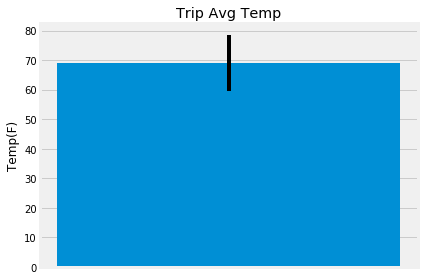

In [34]:
# Plot the results

from scipy.stats import sem

st = sem([tmin, tmax])
fig,a = plt.subplots()
p1 = a.bar(1,tavg, yerr=st)
a.xaxis.set_visible(False)

plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

fig.tight_layout()

plt.savefig("Images/trip_avg_temp.png")

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [36]:
session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= date_one_year_ago).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128',
  147.81000000000006,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  70.03000000000003,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  48.510000000000026,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  38.01,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  33.239999999999995,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  16.089999999999986,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 4.59, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

# Optional Challenge Assignment

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [39]:
from datetime import timedelta, date
date = []
tmin = []
tavg = []
tmax = []

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = datetime.date(2016, 1, 26)
end_dt = datetime.date(2016, 2, 8)

for dt in daterange(start_dt, end_dt):
    dates = (dt.strftime("%Y-%m-%d"))
    mnth_date = (dt.strftime("%m-%d"))
    normals = daily_normals(mnth_date)
    print(normals)

    date.append(dates)
    tmin.append(normals[0][0])
    tavg.append(normals[0][1])
    tmax.append(normals[0][2])


[(61.0, 70.58620689655173, 77.0)]
[(59.0, 68.56896551724138, 75.0)]
[(62.0, 69.03703703703704, 77.0)]
[(64.0, 69.14, 76.0)]
[(60.0, 67.12962962962963, 77.0)]
[(60.0, 68.47368421052632, 74.0)]
[(56.0, 68.14035087719299, 78.0)]
[(59.0, 68.85964912280701, 77.0)]
[(58.0, 67.79661016949153, 77.0)]
[(61.0, 68.14035087719299, 76.0)]
[(59.0, 69.6842105263158, 80.0)]
[(58.0, 70.38983050847457, 77.0)]
[(60.0, 69.0, 77.0)]
[(56.0, 66.75438596491227, 74.0)]


In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df_final = pd.DataFrame({'date':date, 'tmin':tmin, 'tavg':tavg, 'tmax':tmax},
                         )

df_final = df_final.set_index('date')

df_final

,tavg,tmax,tmin
date,,,
2016-01-26,70.586207,77.0,61.0
2016-01-27,68.568966,75.0,59.0
2016-01-28,69.037037,77.0,62.0
2016-01-29,69.140000,76.0,64.0
2016-01-30,67.129630,77.0,60.0
2016-01-31,68.473684,74.0,60.0
2016-02-01,68.140351,78.0,56.0
2016-02-02,68.859649,77.0,59.0
2016-02-03,67.796610,77.0,58.0


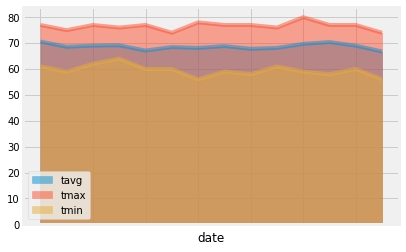

In [41]:
# Plot the daily normals as an area plot with `stacked=False`

df_final.plot.area(stacked=False)

plt.savefig("Images/temp_ara_plot.png")